In [1]:
#Authors: Akbota Assan (A69037121), Devana Perupurayil (A69034326), Melissa Medina-Peregrina (A59016508)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
from scipy.stats import norm

In [2]:
#Step 1

detector_A = pd.read_csv('DetectorA.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])
detector_B = pd.read_csv('DetectorB.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])
detector_C = pd.read_csv('DetectorC.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])
detector_Target = pd.read_csv('DetectorTarget.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])

In [3]:
detector_A

,ID,cnn_score,Energy
0,371804.0,0.302,2614.488
1,594581.0,0.600,1705.200
2,1032837.0,0.481,1267.713
3,959143.0,0.154,2615.730
4,930779.0,0.093,1699.004
...,...,...,...
39995,440702.0,0.006,1465.075
39996,970685.0,0.018,1350.027
39997,226138.0,0.564,1126.152
39998,374147.0,0.587,1350.153


In [4]:
A_min_energy = detector_A["Energy"].min()
A_max_energy = detector_A["Energy"].max()
B_min_energy = detector_B["Energy"].min()
B_max_energy = detector_B["Energy"].max()
C_min_energy = detector_C["Energy"].min()
C_max_energy = detector_C["Energy"].max()
Target_min_energy = detector_Target["Energy"].min()
Target_max_energy = detector_Target["Energy"].max()



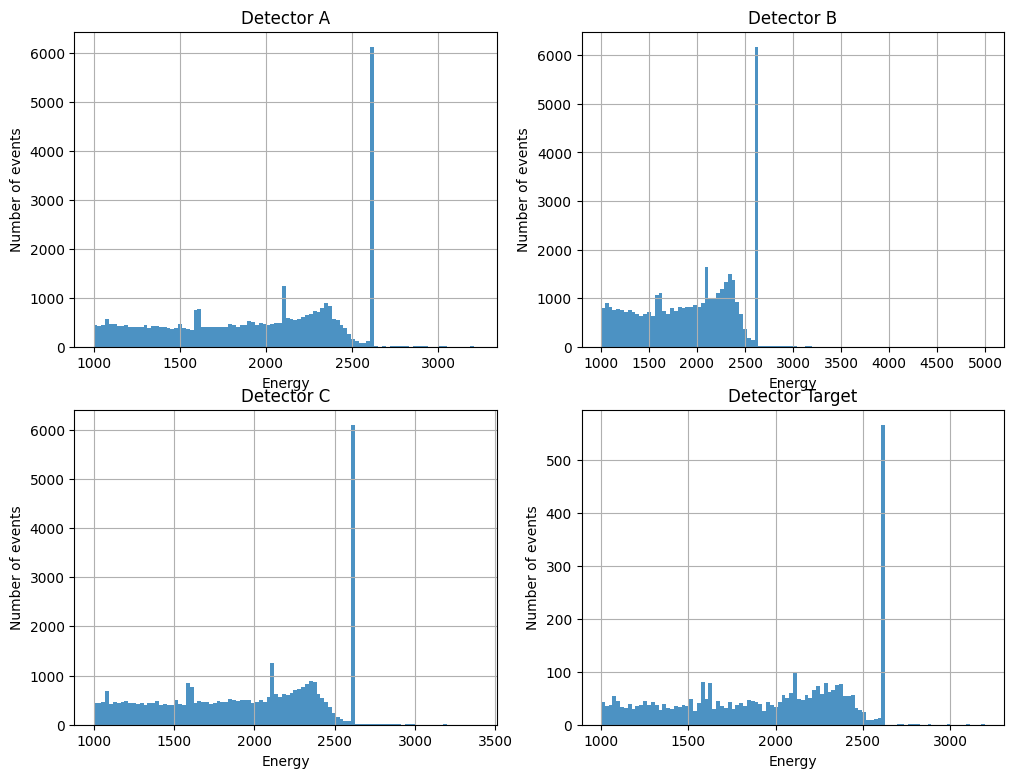

In [5]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
plt.hist(detector_A["Energy"], bins=100, alpha=0.8, range=(A_min_energy, A_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector A')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(detector_B["Energy"], bins=100, alpha=0.8, range=(B_min_energy, B_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector B')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(detector_C["Energy"], bins=100, alpha=0.8, range=(C_min_energy, C_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector C')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(detector_Target["Energy"], bins=100, alpha=0.8, range=(Target_min_energy, Target_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector Target')
plt.grid(True)

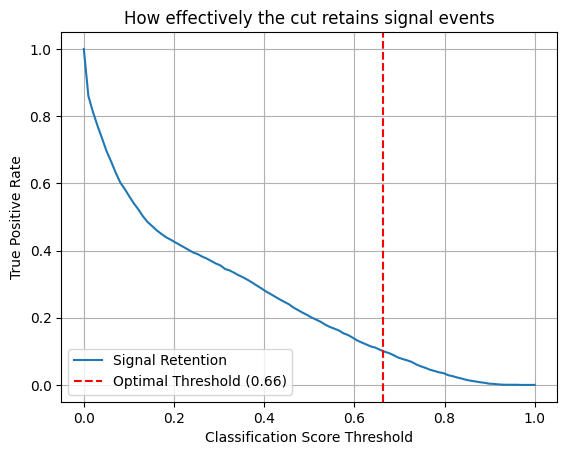

In [6]:
#Step 2

#Identify energy range around the 1592 keV peak
Peak_A = (detector_A["Energy"]>=1492)&(detector_A["Energy"]<=1692)
Peak_A_events = detector_A[Peak_A] 

#Take values with cnn_score above 90% as acceptable threshold
Threshold = np.percentile(Peak_A_events["cnn_score"], 90)
Thresholds = np.linspace(0, 1, 100)

True_Positive = len(Peak_A_events[Peak_A_events["cnn_score"]>=Threshold])
False_Negative = len(Peak_A_events[Peak_A_events["cnn_score"]<Threshold])
Signal = True_Positive+False_Negative
True_Positive_Rate = True_Positive/Signal
        
# Plot the signal retention as a function of threshold
plt.plot(Thresholds, [len(Peak_A_events[Peak_A_events["cnn_score"] >= t]) / len(Peak_A_events) for t in Thresholds], label="Signal Retention")
plt.axvline(Threshold, color='r', linestyle='--', label=f"Optimal Threshold ({Threshold:.2f})")
plt.xlabel("Classification Score Threshold")
plt.ylabel("True Positive Rate")
plt.title("How effectively the cut retains signal events")
plt.legend()
plt.grid()
plt.show()

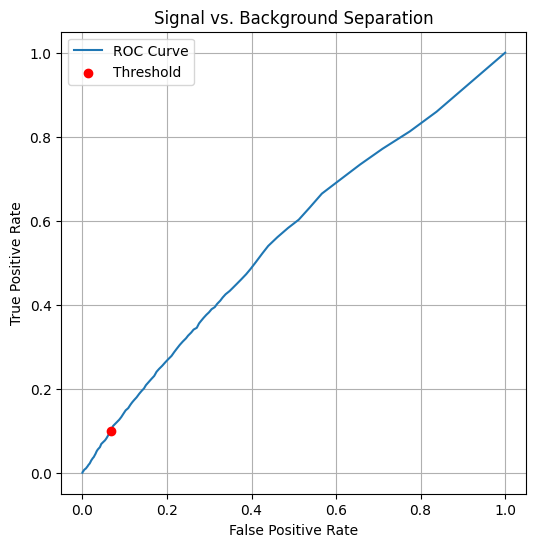

In [7]:
#Step 3

#Identify energy range around the 2103 keV peak
Peak_B = (detector_B["Energy"]>=2003)&(detector_B["Energy"]<=2203)
Peak_B_events = detector_A[Peak_B]

#Events in the 2103 keV region

False_positive = len(Peak_B_events[Peak_B_events["cnn_score"] >= Threshold])
True_Negative = len(Peak_B_events[Peak_B_events["cnn_score"]<Threshold]) 
Background = False_positive+True_Negative
False_Positive_Rate = False_positive/Background

# Sweep different thresholds
#thresholds = np.linspace(0, 1, 100)
TPR_values = [(Peak_A_events["cnn_score"] >= t).sum()/Signal for t in Thresholds]
FPR_values = [(Peak_B_events["cnn_score"] >= t).sum()/Background for t in Thresholds]

plt.figure(figsize=(6, 6))
plt.plot(FPR_values, TPR_values, label="ROC Curve")
plt.scatter(False_Positive_Rate, True_Positive_Rate, color="red", label="Threshold", zorder=3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Signal vs. Background Separation")
plt.legend()
plt.grid()
plt.show()

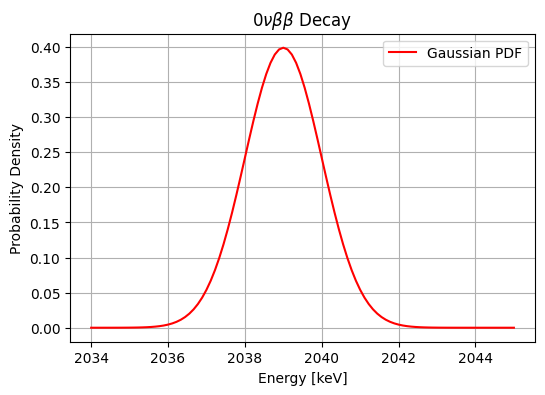

In [8]:
#Step 4

#Gaussian parameters sigma and peak energy
sigma = 1 
mu = 2039
E = np.linspace(2034, 2045, 100)

Gaussian_PDF = norm.pdf(E,mu,sigma)

plt.figure(figsize=(6, 4))
plt.plot(E, Gaussian_PDF, label=r'Gaussian PDF', color='r')
plt.xlabel("Energy [keV]")
plt.ylabel("Probability Density")
plt.title("$0\\nu\\beta\\beta$ Decay")
plt.legend()
plt.grid()
plt.show()

### Step 5

We will be applying a cut around the mean values plus/minus one standard deviation for detector A and B. 
For detector C and Target Data we will start off with a lower cut bound of 500 and an upper cut value of 2500

In [9]:
A_cut_range = [1250, 1450]
B_cut_range = [500, 1040]
C_cut_range = [1000, 2500]
target_cut_range = [1000, 2500]

In [10]:
detectorA_cut = detector_A[(detector_A['Energy']>= A_cut_range[0])  & (detector_A['Energy'] <= A_cut_range[1])]
detectorB_cut = detector_B[(detector_B['Energy']>= B_cut_range[0])  & (detector_B['Energy'] <= B_cut_range[1])]

# Starting with an initial guess for cut bounds for detector C and target
detectorC_cut = detector_C[(detector_C['Energy']>= C_cut_range[0])  & (detector_C['Energy'] <= C_cut_range[1])]
target_cut = detector_Target[(detector_Target['Energy']>= target_cut_range[0])  & (detector_Target['Energy'] <= target_cut_range[1])]

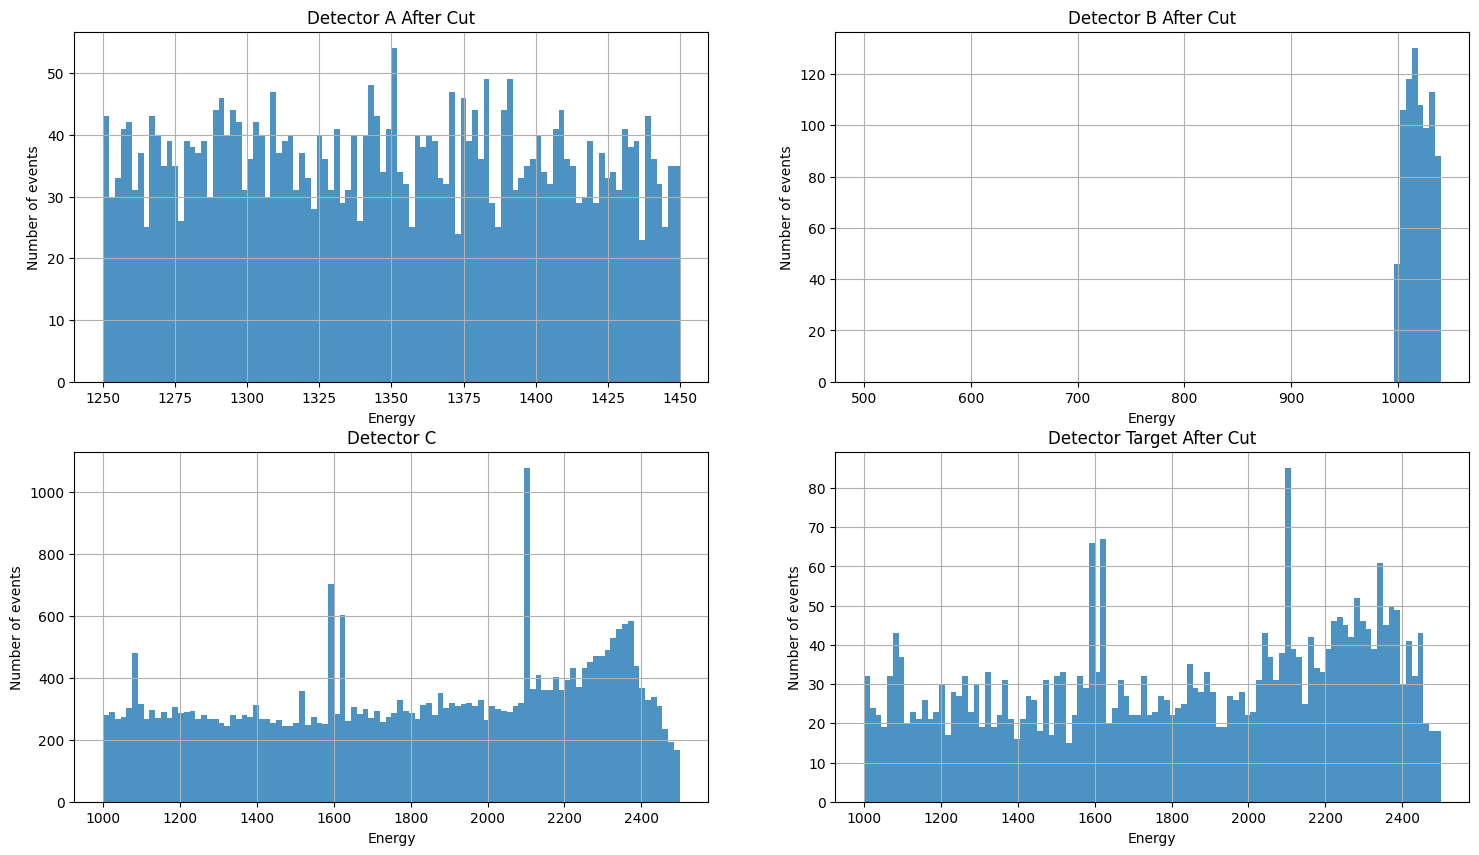

In [11]:
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.hist(detectorA_cut["Energy"], bins=100, alpha=0.8, range=(A_cut_range[0], A_cut_range[1]))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector A After Cut')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(detectorB_cut["Energy"], bins=100, alpha=0.8, range=(B_cut_range[0], B_cut_range[1]))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector B After Cut')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(detectorC_cut["Energy"], bins=100, alpha=0.8, range=(C_cut_range[0], C_cut_range[1]))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector C')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(target_cut["Energy"], bins=100, alpha=0.8, range=(target_cut_range[0], target_cut_range[1]))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector Target After Cut')
plt.grid(True)

Let's now try to fit the histogram into the Gaussian PDF 

In [12]:
from statistics import NormalDist
normA = NormalDist.from_samples(detectorA_cut['Energy'])
normB = NormalDist.from_samples(detectorB_cut['Energy'])
normC = NormalDist.from_samples(detectorC_cut['Energy'])
normTarget = NormalDist.from_samples(target_cut['Energy'])

Estimated mean and standard deviation for C are: 

In [13]:
print(normC.mean)
print(normC.stdev)

1804.0442404378157
433.8727271430957


Let's generate the values for our detectors PDF plots based on estimated mean and standard deviation 

In [14]:
pdfA_x = np.linspace(normA.mean - 3*normA.stdev, normA.mean + 3*normA.stdev, 100) 
pdfA_values = norm.pdf(pdfA_x, normA.mean, normA.stdev)

pdfB_x = np.linspace(normB.mean - 3*normB.stdev, normB.mean + 3*normB.stdev, 100) 
pdfB_values = norm.pdf(pdfB_x, normB.mean, normB.stdev)

pdfC_x = np.linspace(normC.mean - 3*normC.stdev, normC.mean + 3*normC.stdev, 100) 
pdfC_values = norm.pdf(pdfC_x, normC.mean, normC.stdev)

pdfTarget_x = np.linspace(normTarget.mean - 3*normTarget.stdev, normTarget.mean + 3*normTarget.stdev, 100) 
pdfTarget_values = norm.pdf(pdfTarget_x, normTarget.mean, normTarget.stdev)

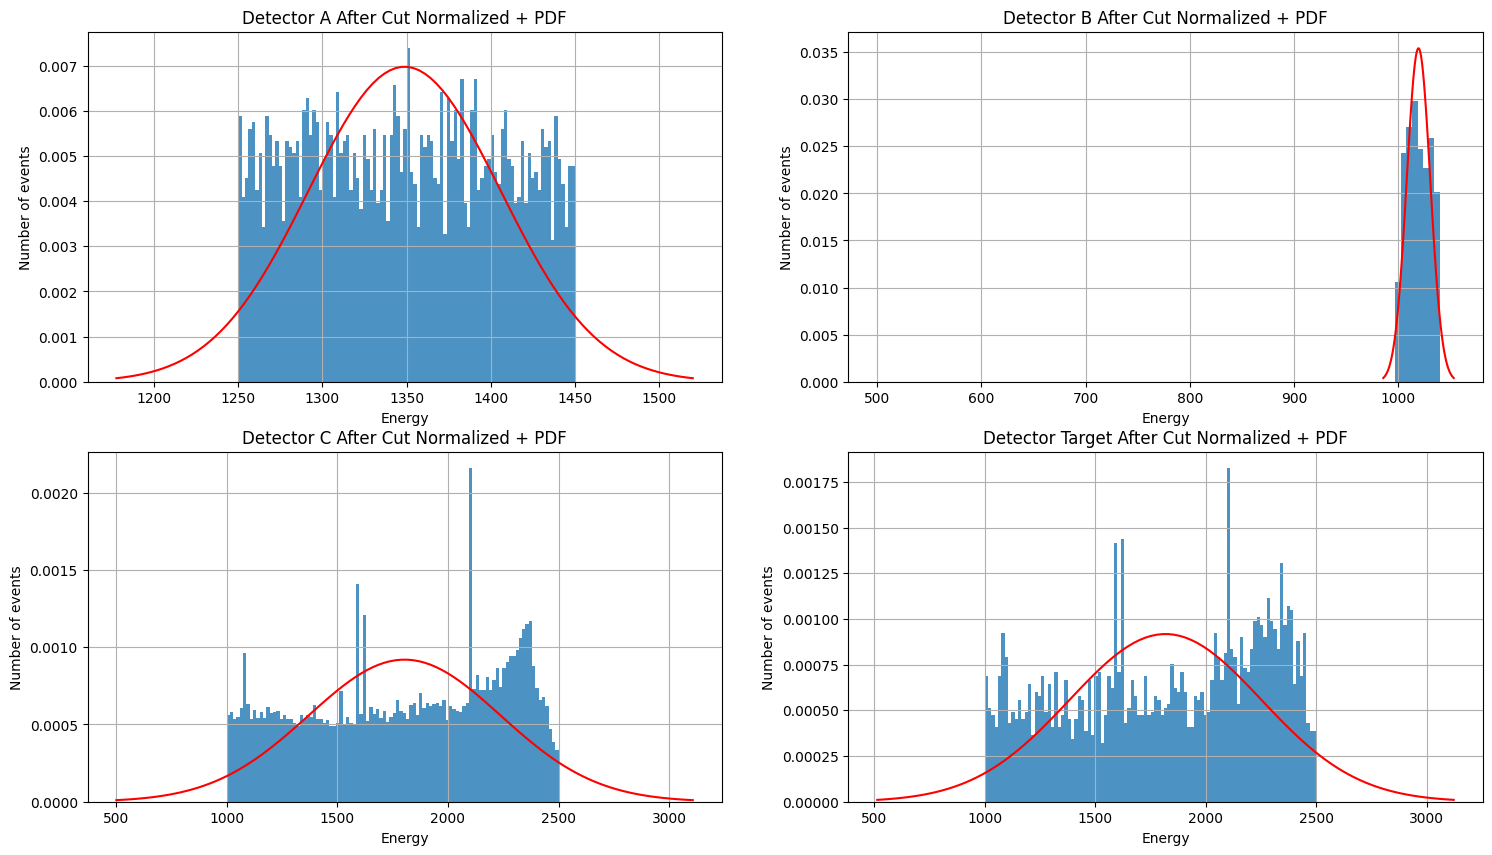

In [15]:
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.hist(detectorA_cut["Energy"], density=True,  bins=100, alpha=0.8, range=(A_cut_range[0], A_cut_range[1]))
plt.plot(pdfA_x, pdfA_values, color='red')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector A After Cut Normalized + PDF')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(detectorB_cut["Energy"], density=True, bins=100, alpha=0.8, range=(B_cut_range[0], B_cut_range[1]))
plt.plot(pdfB_x, pdfB_values, color='red')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector B After Cut Normalized + PDF')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(detectorC_cut["Energy"], density=True, bins=100, alpha=0.8, range=(C_cut_range[0], C_cut_range[1]))
plt.plot(pdfC_x, pdfC_values, color='red')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector C After Cut Normalized + PDF')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(target_cut["Energy"], density=True, bins=100, alpha=0.8, range=(target_cut_range[0], target_cut_range[1]))
plt.plot(pdfTarget_x, pdfTarget_values, color='red')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector Target After Cut Normalized + PDF')
plt.grid(True)

### Part 8 

Let's assume that the backgrount noise data clusters around the mean of 2103. We will need to transform it into an Asimov data/fake data and then perform an MCMC fit to obtain the 90% Credible Interval.

We set the number of bins to be 100. We set the count of events in each bin to be around 21. 

In [63]:
azimov_range = [500, 1500]
azimov_x = np.linspace(azimov_range[0], azimov_range[1], 101) 
bin_num_events = 21

def gen_azimov_data(azimov_x, bin_num_events):
    azimov_y = []
    for i in range(len(azimov_x)):
        if i < len(azimov_x) - 1:
            for k in range(bin_num_events):
                azimov_y.append(uniform(azimov_x[i], azimov_x[i+1]))
    return azimov_y

In [64]:
azimov_y = gen_azimov_data(azimov_x, 21)

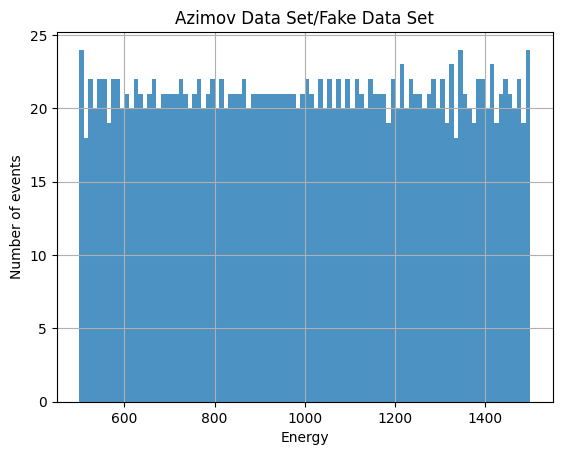

In [65]:
plt.hist(azimov_y, bins=100, alpha=0.8)
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Azimov Data Set/Fake Data Set')
plt.grid(True)